In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [25]:
import pandas as pd
df = pd.read_csv("online_shoppers_intention.csv", encoding="latin1")

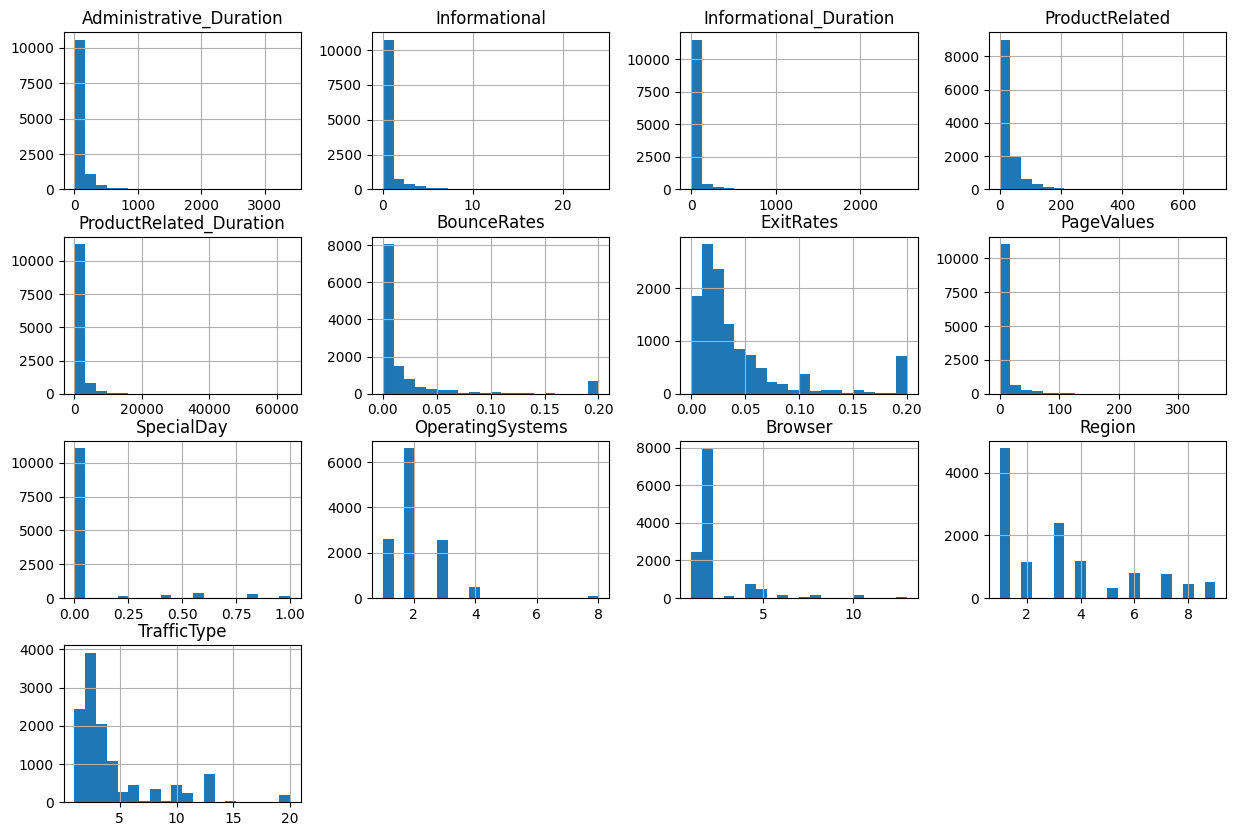

In [26]:
import matplotlib.pyplot as plt
df.select_dtypes(include="number").hist(bins=20, figsize=(15,10))
plt.show()


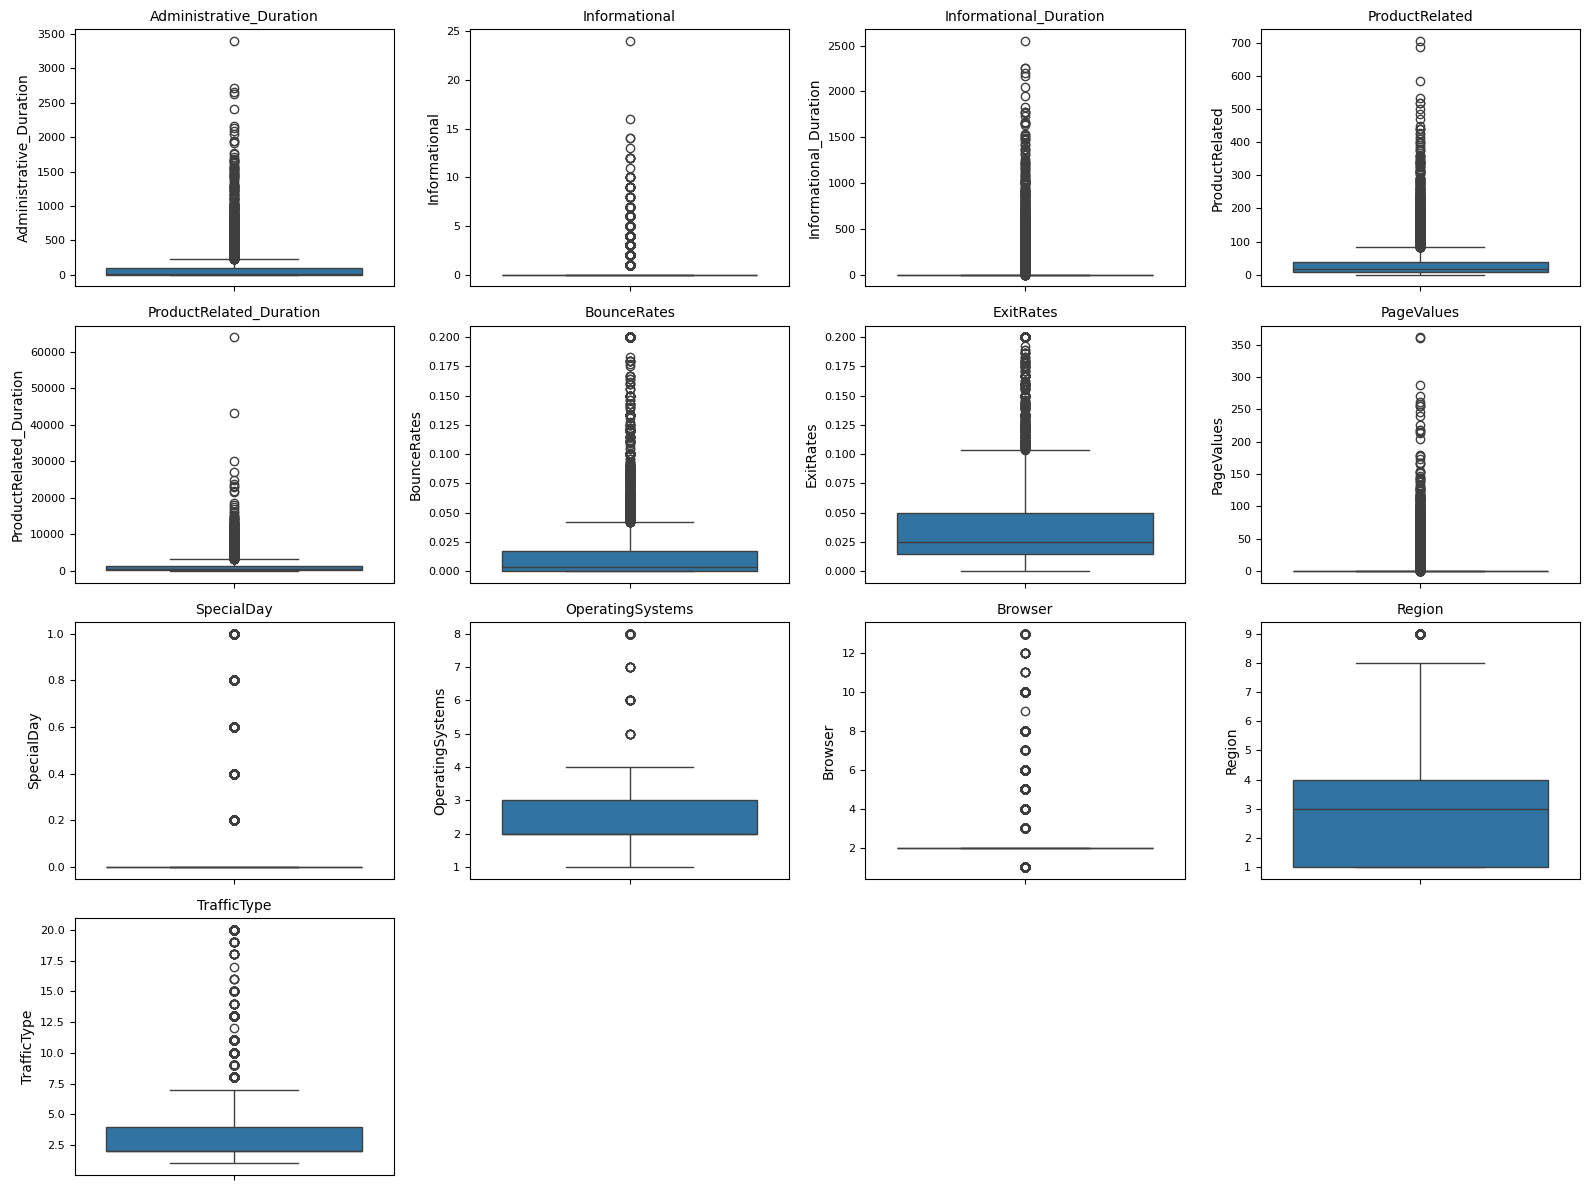

In [31]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
num_cols = df.select_dtypes(include="number").columns
n_cols = 4
n_rows = math.ceil(len(num_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

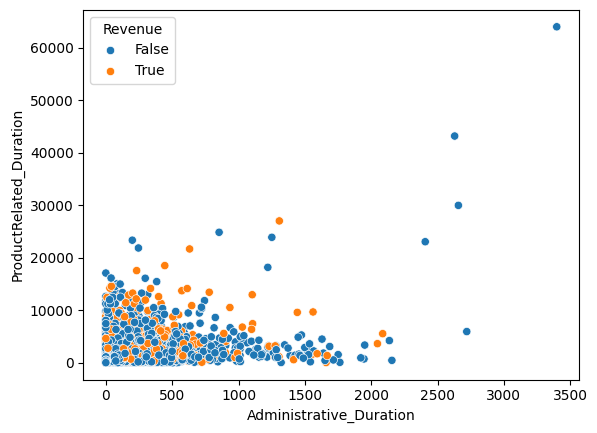

In [5]:
sns.scatterplot(x="Administrative_Duration", y="ProductRelated_Duration", hue="Revenue", data=df)
plt.show()


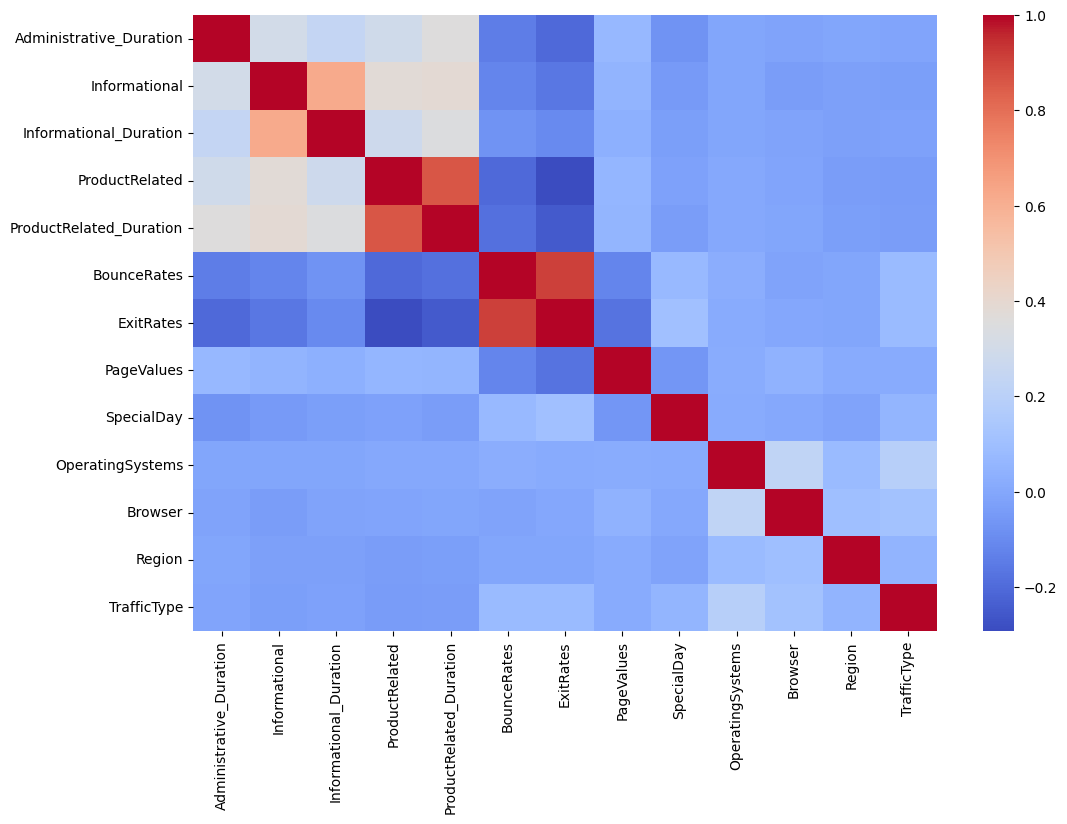

In [6]:
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, cmap="coolwarm")
plt.show()


In [7]:
import numpy as np
df_out = df.copy()

num_cols = df_out.select_dtypes(include="number").columns
for col in num_cols:
    Q1 = df_out[col].quantile(0.25)
    Q3 = df_out[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df_out[col] = np.clip(df_out[col], lower, upper)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# remove junk column if present (PK...)
df_out = df_out.loc[:, ~df_out.columns.str.contains("PK", case=False, na=False)]

# target + features
df_out = df_out.dropna(subset=["Revenue"])
X = df_out.drop("Revenue", axis=1)
y = df_out["Revenue"].astype(int)

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=10)
X_train_fs = selector.fit_transform(X_train_p, y_train)
X_test_fs  = selector.transform(X_test_p)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 1  2  7  8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


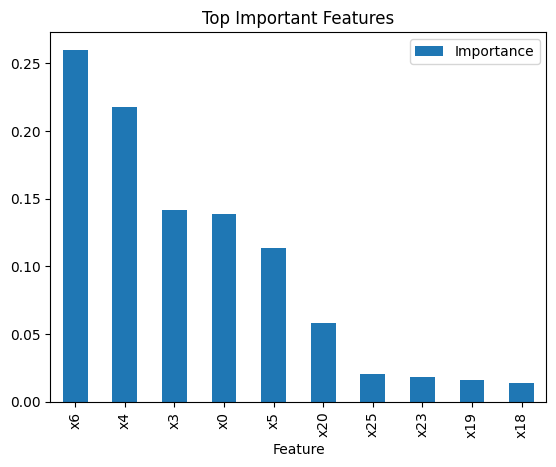

In [18]:
import pandas as pd
import numpy as np

feature_importances = best_model.feature_importances_

features = selector.get_feature_names_out()

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

importance_df.head(10).plot.bar(x="Feature", y="Importance")
plt.title("Top Important Features")
plt.show()


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    Xtr, Xte = X_train_fs, X_test_fs

    # NaiveBayes may require dense
    if name == "NaiveBayes" and hasattr(Xtr, "toarray"):
        Xtr = Xtr.toarray()
        Xte = Xte.toarray()

    model.fit(Xtr, y_train)
    preds = model.predict(Xte)

    print("\n---", name, "---")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))



--- LogisticRegression ---
Accuracy: 0.843065693430657
              precision    recall  f1-score   support

           0       0.85      1.00      0.91      2084
           1       0.22      0.01      0.01       382

    accuracy                           0.84      2466
   macro avg       0.53      0.50      0.46      2466
weighted avg       0.75      0.84      0.77      2466


--- NaiveBayes ---
Accuracy: 0.713300892133009
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      2084
           1       0.29      0.57      0.38       382

    accuracy                           0.71      2466
   macro avg       0.60      0.66      0.60      2466
weighted avg       0.81      0.71      0.75      2466


--- RandomForest ---
Accuracy: 0.83779399837794
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2084
           1       0.44      0.16      0.24       382

    accuracy                 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ANN needs dense arrays
Xtr = X_train_fs.toarray() if hasattr(X_train_fs, "toarray") else X_train_fs
Xte = X_test_fs.toarray() if hasattr(X_test_fs, "toarray") else X_test_fs

ann = Sequential([
    Dense(64, activation="relu", input_shape=(Xtr.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

ann.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
ann.fit(Xtr, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

ann_preds = (ann.predict(Xte) > 0.5).astype(int).ravel()
print("ANN Accuracy:", accuracy_score(y_test, ann_preds))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8210 - loss: 0.4650 - val_accuracy: 0.8469 - val_loss: 0.3743
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8453 - loss: 0.3771 - val_accuracy: 0.8469 - val_loss: 0.3711
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8411 - loss: 0.3886 - val_accuracy: 0.8469 - val_loss: 0.3710
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8454 - loss: 0.3766 - val_accuracy: 0.8459 - val_loss: 0.3702
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8418 - loss: 0.3785 - val_accuracy: 0.8469 - val_loss: 0.3686
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8391 - loss: 0.3810 - val_accuracy: 0.8459 - val_loss: 0.3692
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8467 - loss: 0.3726 - val_accuracy: 0.8454 - val_loss: 0.3693
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8458 - loss: 0.3790 - val_accuracy: 0.

In [12]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

Xtr_cnn = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
Xte_cnn = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

cnn = Sequential([
    Conv1D(32, 3, activation="relu", input_shape=(Xtr_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.fit(Xtr_cnn, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

cnn_preds = (cnn.predict(Xte_cnn) > 0.5).astype(int).ravel()
print("CNN Accuracy:", accuracy_score(y_test, cnn_preds))


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8446 - loss: 0.4364 - val_accuracy: 0.8469 - val_loss: 0.3738
Epoch 2/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8460 - loss: 0.3821 - val_accuracy: 0.8490 - val_loss: 0.3747
Epoch 3/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8466 - loss: 0.3801 - val_accuracy: 0.8459 - val_loss: 0.3743
Epoch 4/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8469 - loss: 0.3731 - val_accuracy: 0.8454 - val_loss: 0.3720
Epoch 5/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8400 - loss: 0.3772 - val_accuracy: 0.8449 - val_loss: 0.3706
Epoch 6/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8455 - loss: 0.3714 - val_accuracy: 0.8469 - val_loss: 0.3701
Epoch 7/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8427 - loss: 0.3759 - val_accuracy: 0.8459 - val_loss: 0.3690
Epoch 8/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8479 - loss: 0.3703 - val_accuracy: 0.8459 - val_

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")
grid.fit(X_train_fs, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Params: {'max_depth': 10, 'n_estimators': 100}
Best CV Score: 0.8481346309813462


ROC-AUC: 0.7536848941323071


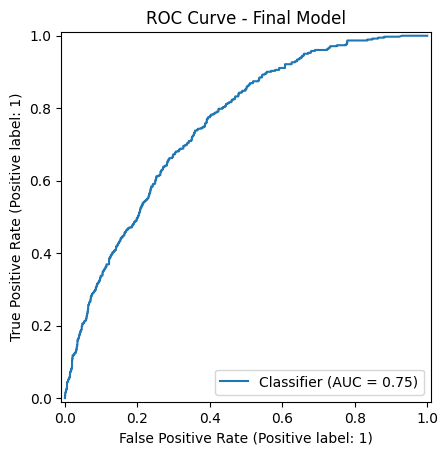

In [16]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

probs = best_model.predict_proba(X_test_fs)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, probs))

RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve - Final Model")
plt.show()


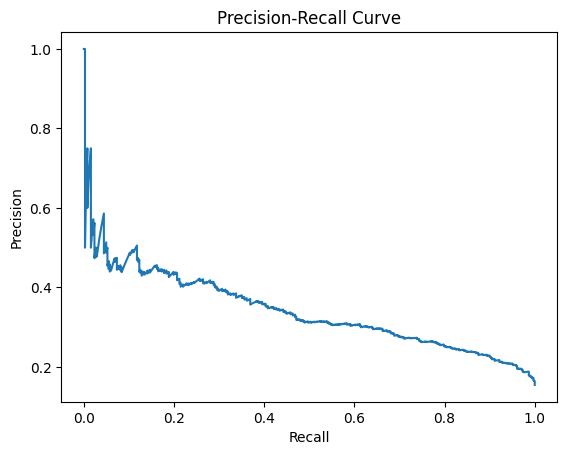

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [14]:
best_model = grid.best_estimator_
final_preds = best_model.predict(X_test_fs)

output = pd.DataFrame({"Actual": y_test.values, "Predicted": final_preds})
output.head(20)


,Actual,Predicted
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
5,0,0
6,1,0
7,0,1
8,0,1
9,0,0


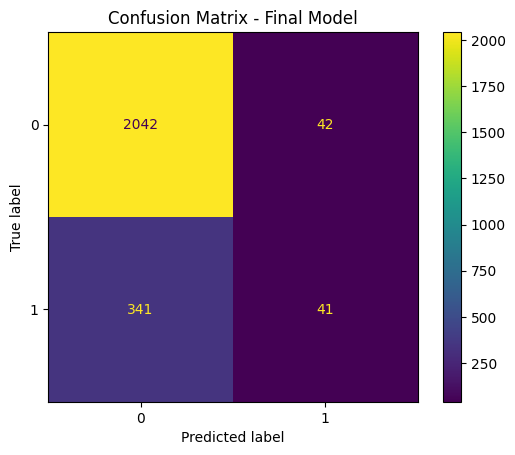

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)
plt.title("Confusion Matrix - Final Model")
plt.show()
